# Experimentando função de pré-processamento de imagem com svm

# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from zipfile import ZipFile
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

from img_edit import preprocessing_img

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8
ZIP_PATH = 'patologias_toras.zip'
# ZIP_PATH = 'toras.zip'
TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile(ZIP_PATH) as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if '__MAC' not in path \
        and '.JPG' in path \
        and folder in TARGET_NAMES:
      path_dict[folder].append(f'./{ZIP_PATH}/{path}')

# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


In [3]:
amostra = []
for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = imread(path)
    img_prepro = preprocessing_img(img)
    # pode acontecer do crop horizontal recortar a imagem toda
    if len(img_prepro) == 0:
      # N_MIN_DE_AMOSTRAS -= 1
      # acontece erro com otsu, pula então a iteração
      continue

    img_otsu = img_prepro >= threshold_otsu(img_prepro)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = hist.values
    # arr = np.zeros(59)
    # for i in hist.index:
    #   arr[int(i)] = hist[i]

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/prepro_1.csv', index=False)
print(data.value_counts())
data

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


0     1     2     3     4     5       6       7       8       9       10      11      12      13     14      15     16      17        18      target
1     14    1     16    1     7.0     14.0    9.0     14.0    137.0   5.0     136.0   3.0     5.0    1.0     5.0    2.0     590.0     44.0    3         1
65    118   123   128   132   399.0   331.0   400.0   332.0   1659.0  491.0   1667.0  480.0   227.0  261.0   213.0  259.0   78851.0   984.0   2         1
70    172   125   192   120   666.0   874.0   678.0   853.0   3595.0  761.0   3613.0  759.0   844.0  692.0   842.0  678.0   105507.0  1283.0  1         1
      148   64    174   89    456.0   320.0   366.0   373.0   3192.0  302.0   3357.0  311.0   381.0  439.0   317.0  361.0   59330.0   1271.0  2         1
      78    92    92    66    264.0   226.0   278.0   199.0   1710.0  280.0   1662.0  277.0   177.0  222.0   199.0  249.0   60347.0   663.0   1         1
                                                                                 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,target
0,50,64,35,65,43,186.0,161.0,138.0,249.0,846.0,321.0,995.0,282.0,286.0,231.0,197.0,180.0,73898.0,329.0,0
1,148,137,130,142,146,302.0,199.0,204.0,226.0,848.0,241.0,984.0,302.0,167.0,233.0,131.0,141.0,77146.0,981.0,0
2,18,45,16,53,26,183.0,134.0,120.0,221.0,943.0,326.0,1118.0,287.0,274.0,231.0,167.0,164.0,55677.0,285.0,0
3,130,208,117,207,86,351.0,315.0,378.0,321.0,1774.0,468.0,1752.0,439.0,347.0,358.0,332.0,380.0,78012.0,1162.0,0
4,47,118,51,111,64,250.0,288.0,253.0,314.0,2299.0,274.0,2329.0,247.0,341.0,284.0,320.0,292.0,45502.0,663.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20,44,26,49,27,129.0,140.0,112.0,130.0,557.0,109.0,572.0,130.0,113.0,107.0,117.0,87.0,10036.0,263.0,3
354,16,35,27,35,20,141.0,159.0,151.0,138.0,675.0,140.0,656.0,150.0,138.0,139.0,152.0,145.0,14816.0,241.0,3
355,4,23,7,24,6,40.0,54.0,35.0,61.0,397.0,46.0,395.0,43.0,53.0,38.0,52.0,41.0,3933.0,169.0,3
356,18,61,25,60,29,145.0,166.0,134.0,169.0,654.0,132.0,682.0,140.0,138.0,123.0,129.0,107.0,12535.0,303.0,3


In [4]:
# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                            #  accuracy_score,
                            #  confusion_matrix,
                            #  f1_score,
                             plot_confusion_matrix)

0    88
1    88
2    87
3    85
Name: target, dtype: int64
Rodada 0	-	Seed 686
              precision    recall  f1-score   support

      normal       0.44      0.28      0.34        29
       broca       0.67      0.15      0.25        26
     fissura       0.40      0.64      0.49        22
       musgo       0.43      0.71      0.54        28

    accuracy                           0.44       105
   macro avg       0.49      0.45      0.41       105
weighted avg       0.49      0.44      0.40       105



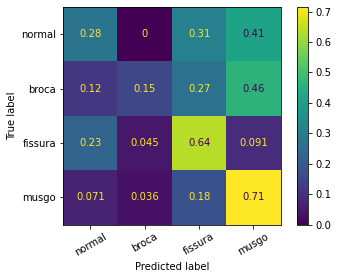

Rodada 1	-	Seed 899
              precision    recall  f1-score   support

      normal       0.33      0.73      0.45        26
       broca       0.22      0.10      0.14        20
     fissura       0.68      0.54      0.60        28
       musgo       0.44      0.23      0.30        31

    accuracy                           0.41       105
   macro avg       0.42      0.40      0.37       105
weighted avg       0.43      0.41      0.39       105



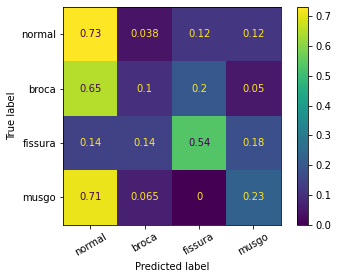

Rodada 2	-	Seed 5560
              precision    recall  f1-score   support

      normal       0.40      0.32      0.36        25
       broca       0.57      0.14      0.22        29
     fissura       0.38      0.56      0.45        25
       musgo       0.51      0.81      0.63        26

    accuracy                           0.45       105
   macro avg       0.47      0.46      0.41       105
weighted avg       0.47      0.45      0.41       105



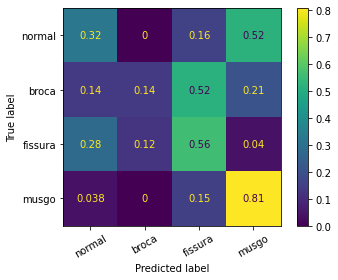

Rodada 3	-	Seed 2267
              precision    recall  f1-score   support

      normal       0.50      0.27      0.35        22
       broca       0.33      0.15      0.21        27
     fissura       0.36      0.54      0.43        26
       musgo       0.52      0.73      0.61        30

    accuracy                           0.44       105
   macro avg       0.43      0.42      0.40       105
weighted avg       0.43      0.44      0.41       105



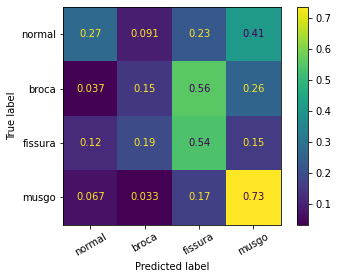

Rodada 4	-	Seed 4110
              precision    recall  f1-score   support

      normal       0.67      0.26      0.37        31
       broca       0.43      0.09      0.15        32
     fissura       0.37      0.78      0.50        18
       musgo       0.35      0.71      0.47        24

    accuracy                           0.40       105
   macro avg       0.45      0.46      0.37       105
weighted avg       0.47      0.40      0.35       105



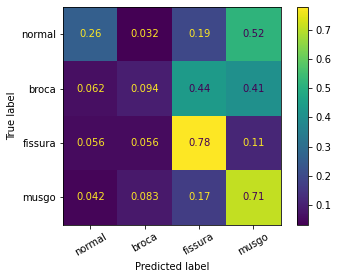

Rodada 5	-	Seed 5033
              precision    recall  f1-score   support

      normal       0.60      0.32      0.42        28
       broca       0.33      0.08      0.13        24
     fissura       0.55      0.55      0.55        33
       musgo       0.35      0.90      0.51        20

    accuracy                           0.45       105
   macro avg       0.46      0.46      0.40       105
weighted avg       0.47      0.45      0.41       105



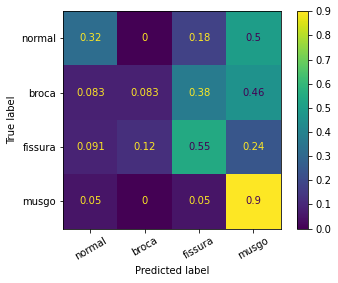

Rodada 6	-	Seed 7114
              precision    recall  f1-score   support

      normal       0.60      0.17      0.27        35
       broca       0.60      0.13      0.21        23
     fissura       0.53      0.68      0.60        25
       musgo       0.31      0.82      0.45        22

    accuracy                           0.42       105
   macro avg       0.51      0.45      0.38       105
weighted avg       0.52      0.42      0.37       105



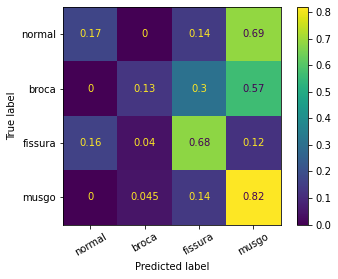

Rodada 7	-	Seed 7530
              precision    recall  f1-score   support

      normal       0.33      0.20      0.25        25
       broca       0.57      0.11      0.19        36
     fissura       0.32      0.52      0.40        21
       musgo       0.39      0.83      0.53        23

    accuracy                           0.37       105
   macro avg       0.40      0.42      0.34       105
weighted avg       0.42      0.37      0.32       105



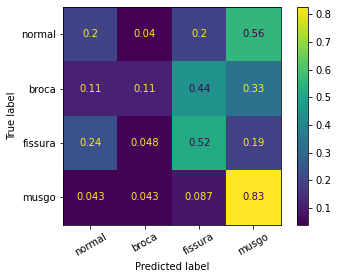

Rodada 8	-	Seed 210
              precision    recall  f1-score   support

      normal       0.39      0.28      0.33        25
       broca       0.33      0.08      0.13        25
     fissura       0.41      0.59      0.48        22
       musgo       0.41      0.61      0.49        33

    accuracy                           0.40       105
   macro avg       0.38      0.39      0.36       105
weighted avg       0.39      0.40      0.36       105



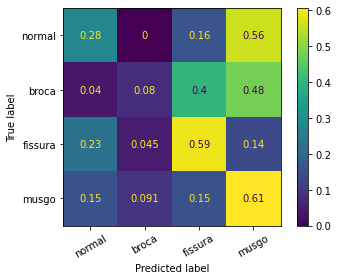

Rodada 9	-	Seed 3966
              precision    recall  f1-score   support

      normal       0.69      0.39      0.50        28
       broca       0.60      0.12      0.21        24
     fissura       0.47      0.77      0.59        22
       musgo       0.50      0.77      0.61        31

    accuracy                           0.52       105
   macro avg       0.56      0.52      0.48       105
weighted avg       0.57      0.52      0.48       105



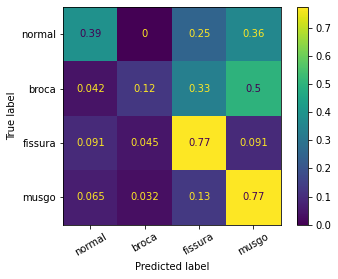

Rodada 10	-	Seed 6479
              precision    recall  f1-score   support

      normal       0.53      0.30      0.38        27
       broca       0.50      0.15      0.24        26
     fissura       0.53      0.69      0.60        26
       musgo       0.48      0.88      0.62        26

    accuracy                           0.50       105
   macro avg       0.51      0.51      0.46       105
weighted avg       0.51      0.50      0.46       105



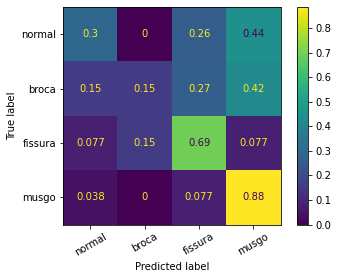

Rodada 11	-	Seed 3224
              precision    recall  f1-score   support

      normal       0.53      0.29      0.38        31
       broca       0.62      0.31      0.41        26
     fissura       0.47      0.67      0.55        24
       musgo       0.46      0.79      0.58        24

    accuracy                           0.50       105
   macro avg       0.52      0.51      0.48       105
weighted avg       0.52      0.50      0.47       105



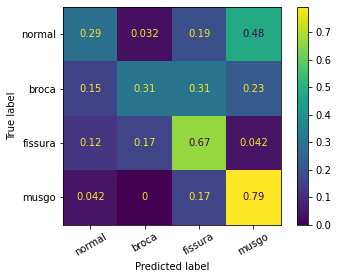

Rodada 12	-	Seed 7025
              precision    recall  f1-score   support

      normal       0.58      0.25      0.35        28
       broca       0.83      0.19      0.31        26
     fissura       0.47      0.82      0.60        22
       musgo       0.43      0.72      0.54        29

    accuracy                           0.49       105
   macro avg       0.58      0.50      0.45       105
weighted avg       0.58      0.49      0.45       105



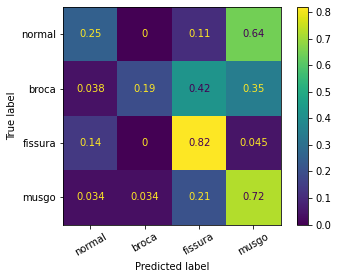

Rodada 13	-	Seed 1640
              precision    recall  f1-score   support

      normal       0.41      0.26      0.32        27
       broca       0.20      0.04      0.07        25
     fissura       0.46      0.63      0.53        27
       musgo       0.39      0.69      0.50        26

    accuracy                           0.41       105
   macro avg       0.37      0.41      0.35       105
weighted avg       0.37      0.41      0.36       105



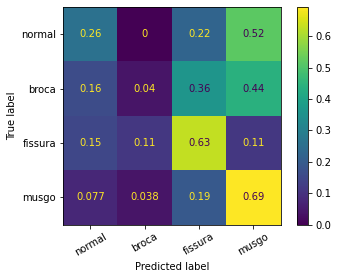

Rodada 14	-	Seed 4217
              precision    recall  f1-score   support

      normal       0.50      0.32      0.39        28
       broca       0.62      0.16      0.26        31
     fissura       0.47      0.56      0.51        27
       musgo       0.30      0.74      0.42        19

    accuracy                           0.41       105
   macro avg       0.47      0.44      0.40       105
weighted avg       0.49      0.41      0.39       105



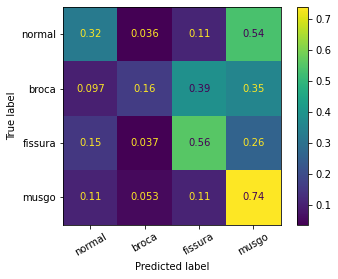

Rodada 15	-	Seed 3476
              precision    recall  f1-score   support

      normal       0.56      0.32      0.41        31
       broca       0.67      0.18      0.29        22
     fissura       0.44      0.62      0.52        26
       musgo       0.42      0.73      0.54        26

    accuracy                           0.47       105
   macro avg       0.52      0.46      0.44       105
weighted avg       0.52      0.47      0.44       105



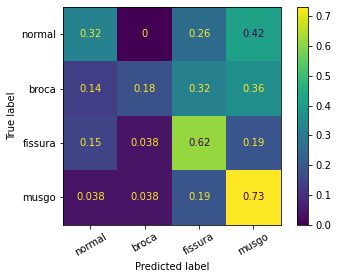

Rodada 16	-	Seed 1448
              precision    recall  f1-score   support

      normal       0.46      0.84      0.59        19
       broca       0.67      0.15      0.25        26
     fissura       0.39      0.54      0.45        26
       musgo       0.71      0.59      0.65        34

    accuracy                           0.51       105
   macro avg       0.56      0.53      0.48       105
weighted avg       0.58      0.51      0.49       105



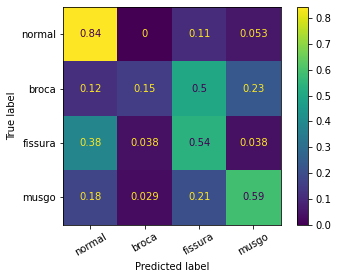

Rodada 17	-	Seed 7868
              precision    recall  f1-score   support

      normal       0.25      0.70      0.36        20
       broca       0.62      0.22      0.32        23
     fissura       0.50      0.76      0.60        25
       musgo       1.00      0.05      0.10        37

    accuracy                           0.38       105
   macro avg       0.59      0.43      0.35       105
weighted avg       0.66      0.38      0.32       105



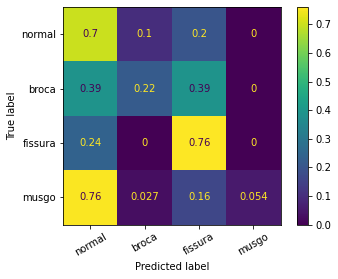

Rodada 18	-	Seed 1901
              precision    recall  f1-score   support

      normal       0.59      0.38      0.47        26
       broca       0.75      0.19      0.30        32
     fissura       0.41      0.70      0.52        23
       musgo       0.49      0.83      0.62        24

    accuracy                           0.50       105
   macro avg       0.56      0.53      0.47       105
weighted avg       0.58      0.50      0.46       105



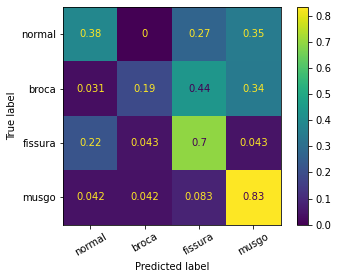

Rodada 19	-	Seed 248
              precision    recall  f1-score   support

      normal       0.46      0.25      0.32        24
       broca       0.27      0.17      0.21        23
     fissura       0.61      0.52      0.56        33
       musgo       0.39      0.76      0.51        25

    accuracy                           0.44       105
   macro avg       0.43      0.42      0.40       105
weighted avg       0.45      0.44      0.42       105



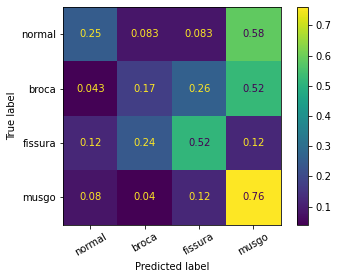

Rodada 20	-	Seed 3963
              precision    recall  f1-score   support

      normal       0.46      0.42      0.44        26
       broca       0.75      0.23      0.35        26
     fissura       0.53      0.59      0.56        29
       musgo       0.49      0.83      0.62        24

    accuracy                           0.51       105
   macro avg       0.56      0.52      0.49       105
weighted avg       0.56      0.51      0.49       105



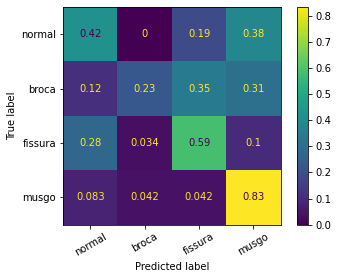

Rodada 21	-	Seed 6025
              precision    recall  f1-score   support

      normal       0.43      0.19      0.26        32
       broca       0.75      0.19      0.31        31
     fissura       0.39      0.67      0.49        24
       musgo       0.33      0.78      0.47        18

    accuracy                           0.40       105
   macro avg       0.48      0.46      0.38       105
weighted avg       0.50      0.40      0.36       105



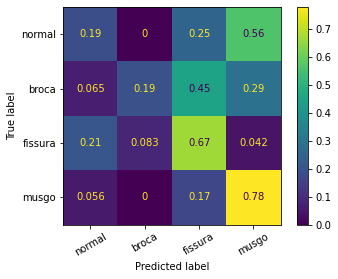

Rodada 22	-	Seed 1165
              precision    recall  f1-score   support

      normal       0.58      0.26      0.36        27
       broca       0.62      0.15      0.24        34
     fissura       0.40      0.76      0.52        21
       musgo       0.38      0.74      0.50        23

    accuracy                           0.43       105
   macro avg       0.50      0.48      0.41       105
weighted avg       0.52      0.43      0.38       105



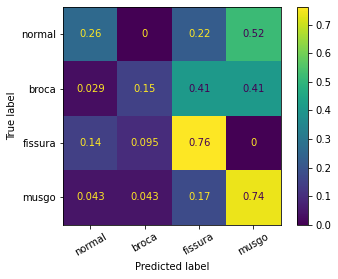

Rodada 23	-	Seed 985
              precision    recall  f1-score   support

      normal       0.62      0.32      0.42        25
       broca       1.00      0.21      0.34        29
     fissura       0.47      0.65      0.55        26
       musgo       0.44      0.88      0.59        25

    accuracy                           0.50       105
   macro avg       0.63      0.52      0.47       105
weighted avg       0.64      0.50      0.47       105



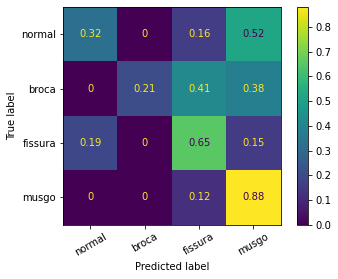

Rodada 24	-	Seed 4189
              precision    recall  f1-score   support

      normal       0.38      0.21      0.27        28
       broca       0.50      0.11      0.18        28
     fissura       0.54      0.66      0.59        29
       musgo       0.31      0.75      0.44        20

    accuracy                           0.41       105
   macro avg       0.43      0.43      0.37       105
weighted avg       0.44      0.41      0.37       105



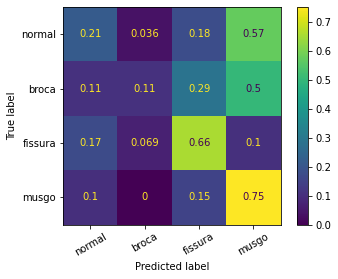

Rodada 25	-	Seed 5764
              precision    recall  f1-score   support

      normal       0.46      0.46      0.46        26
       broca       0.30      0.14      0.19        22
     fissura       0.56      0.61      0.58        31
       musgo       0.43      0.58      0.49        26

    accuracy                           0.47       105
   macro avg       0.44      0.45      0.43       105
weighted avg       0.45      0.47      0.45       105



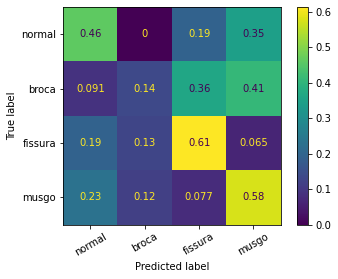

Rodada 26	-	Seed 7795
              precision    recall  f1-score   support

      normal       0.37      0.25      0.30        28
       broca       0.50      0.20      0.29        20
     fissura       0.55      0.63      0.59        27
       musgo       0.53      0.83      0.65        30

    accuracy                           0.50       105
   macro avg       0.49      0.48      0.45       105
weighted avg       0.49      0.50      0.47       105



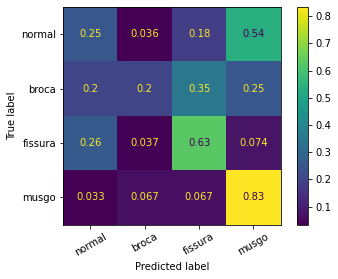

Rodada 27	-	Seed 6625
              precision    recall  f1-score   support

      normal       0.60      0.33      0.43        27
       broca       0.50      0.09      0.15        33
     fissura       0.34      0.57      0.43        21
       musgo       0.45      0.92      0.60        24

    accuracy                           0.44       105
   macro avg       0.47      0.48      0.40       105
weighted avg       0.48      0.44      0.38       105



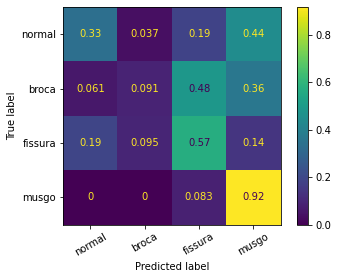

Rodada 28	-	Seed 2695
              precision    recall  f1-score   support

      normal       0.57      0.30      0.39        27
       broca       0.80      0.13      0.22        31
     fissura       0.47      0.64      0.55        28
       musgo       0.29      0.74      0.42        19

    accuracy                           0.42       105
   macro avg       0.53      0.45      0.39       105
weighted avg       0.56      0.42      0.39       105



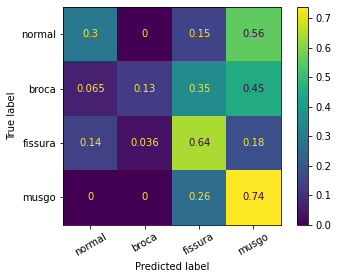

Rodada 29	-	Seed 5049
              precision    recall  f1-score   support

      normal       0.42      0.36      0.39        22
       broca       0.67      0.06      0.11        33
     fissura       0.48      0.71      0.57        28
       musgo       0.37      0.68      0.48        22

    accuracy                           0.43       105
   macro avg       0.48      0.46      0.39       105
weighted avg       0.50      0.43      0.37       105



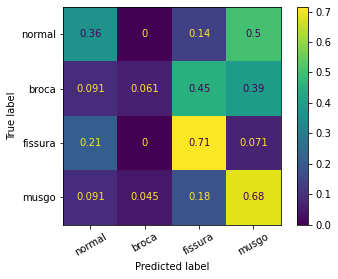

In [5]:
data = pd.read_csv('./csvs/prepro_1.csv').dropna()
print(data['target'].value_counts())

y = data.pop('target').values
X = data.values

acuracias = []

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  # Instanciando classificador com padronizador
  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  
  acuracias.append(clf.score(X_test, y_test))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

count    30.000000
mean      0.446984
std       0.044244
min       0.371429
25%       0.409524
50%       0.438095
75%       0.492857
max       0.523810
Name: Acurácia, dtype: float64


Acurácia
0.438095
0.409524
0.447619
0.438095
0.400000
0.447619
0.419048
0.371429
0.400000
0.523810


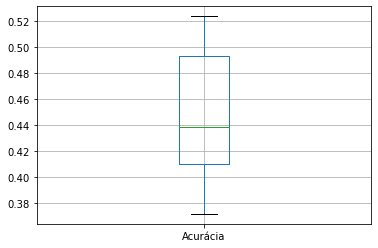

In [6]:
acc_df = pd.Series(data=acuracias, name='Acurácia')

print(acc_df.describe())

acc_df.to_frame().boxplot()

acc_df.to_frame().style.hide_index().background_gradient(cmap='Blues')